# Predictive Analysis for Diabetes

## Importing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, recall_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 

from sklearn.neural_network import MLPClassifier

from keras.models import Sequential   
from keras.layers import Dense

2023-12-06 04:20:28.545655: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 04:20:28.879752: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 04:20:28.887784: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-06 04:20:28.887806: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 
  
# metadata 
print(cdc_diabetes_health_indicators.metadata) 
  
# variable information 
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

## Data Exploration

### Visualizations for Data Exploration

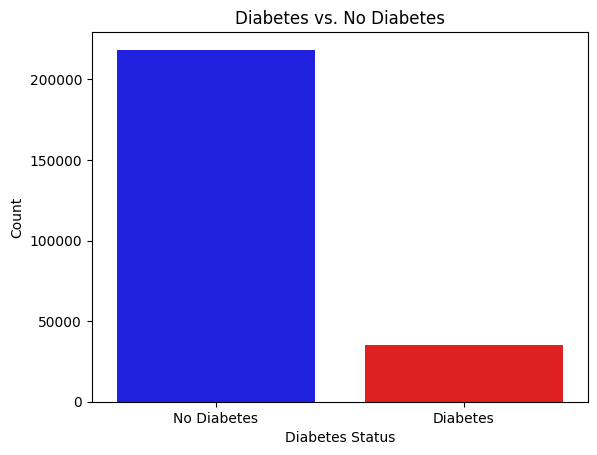

0    218334
1     35346
Name: Diabetes_binary, dtype: int64

In [ ]:
#Visualizations
df = pd.merge(X, y, left_index=True, right_index=True)
ax = sns.countplot(x='Diabetes_binary', data=df, palette=['blue', 'red'], tick_label=['Diabetes', 'No Diabetes'])
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
plt.title('Diabetes vs. No Diabetes')
ax.set_xticklabels(['No Diabetes', 'Diabetes'])
plt.show()
df['Diabetes_binary'].value_counts()

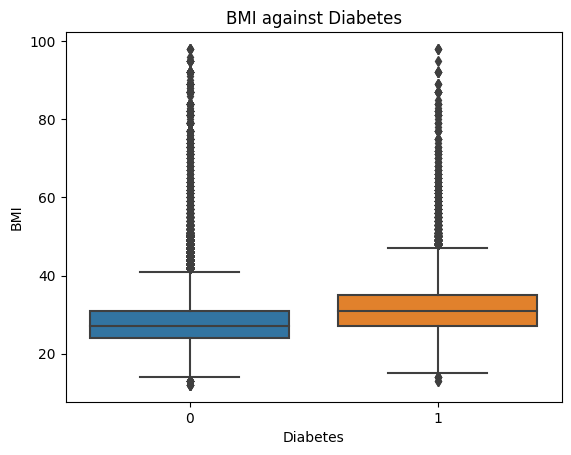

In [ ]:
#Boxplot of BMI vs. diabetes
sns.boxplot(x='Diabetes_binary', y='BMI', data=df)
plt.xlabel('Diabetes')
plt.ylabel('BMI')
plt.title('BMI against Diabetes')
plt.show()

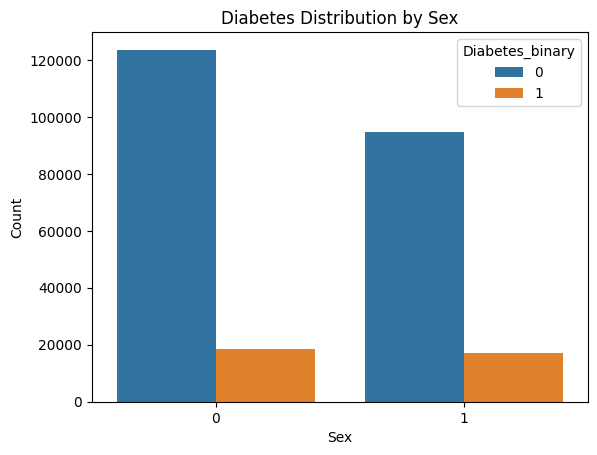

In [ ]:
sns.countplot(x='Sex', hue='Diabetes_binary', data=df)
plt.title('Diabetes Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()
#No significant different between sexes

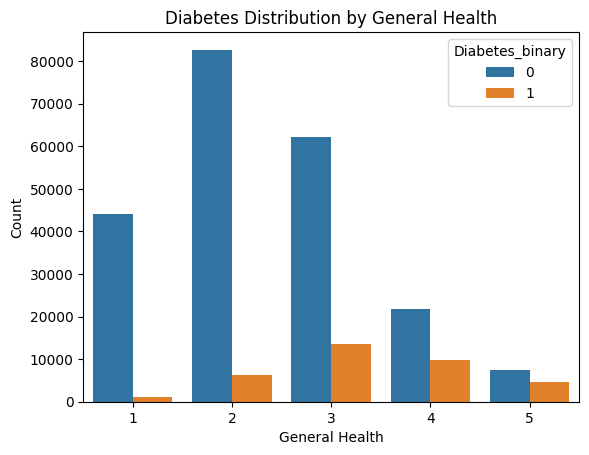

In [ ]:
sns.countplot(x='GenHlth', hue='Diabetes_binary', data=df)
plt.title('Diabetes Distribution by General Health')
plt.xlabel('General Health')
plt.ylabel('Count')
plt.show()

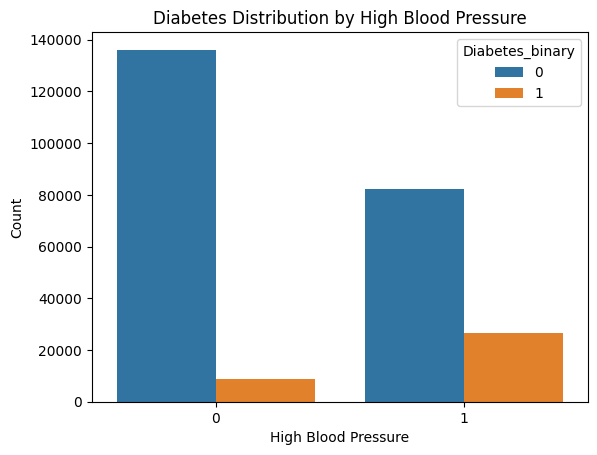

In [ ]:
sns.countplot(x='HighBP', hue='Diabetes_binary', data=df)
plt.title('Diabetes Distribution by High Blood Pressure')
plt.xlabel('High Blood Pressure')
plt.ylabel('Count')
plt.show()

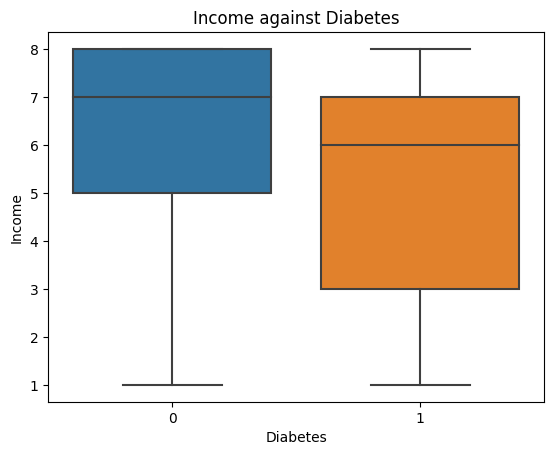

In [ ]:
sns.boxplot(x='Diabetes_binary', y='Income', data=df)
plt.xlabel('Diabetes')
plt.ylabel('Income')
plt.title('Income against Diabetes')
plt.show()

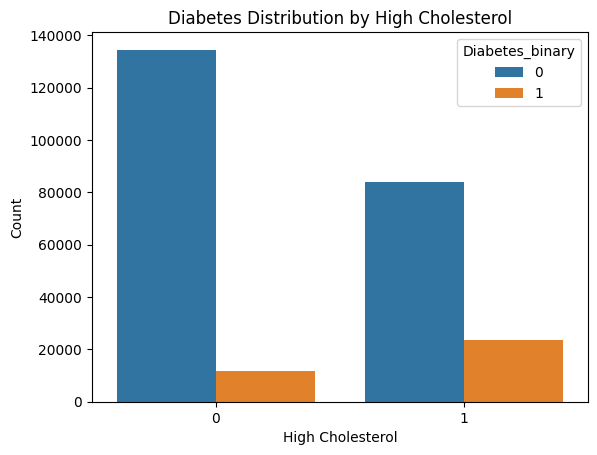

In [ ]:
sns.countplot(x='HighChol', hue='Diabetes_binary', data=df)
plt.title('Diabetes Distribution by High Cholesterol')
plt.xlabel('High Cholesterol')
plt.ylabel('Count')
plt.show()

In [ ]:
# Number of unique values for each variable 
X.nunique()

HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

In [ ]:
# Checking for class imbalance
class_distribution = y['Diabetes_binary'].value_counts(normalize=True)
print(class_distribution)

0    0.860667
1    0.139333
Name: Diabetes_binary, dtype: float64


There is an underrepresentation of diabetes in the dataset. Will need to over/undersample to make the data more even for analysis.

<AxesSubplot: >

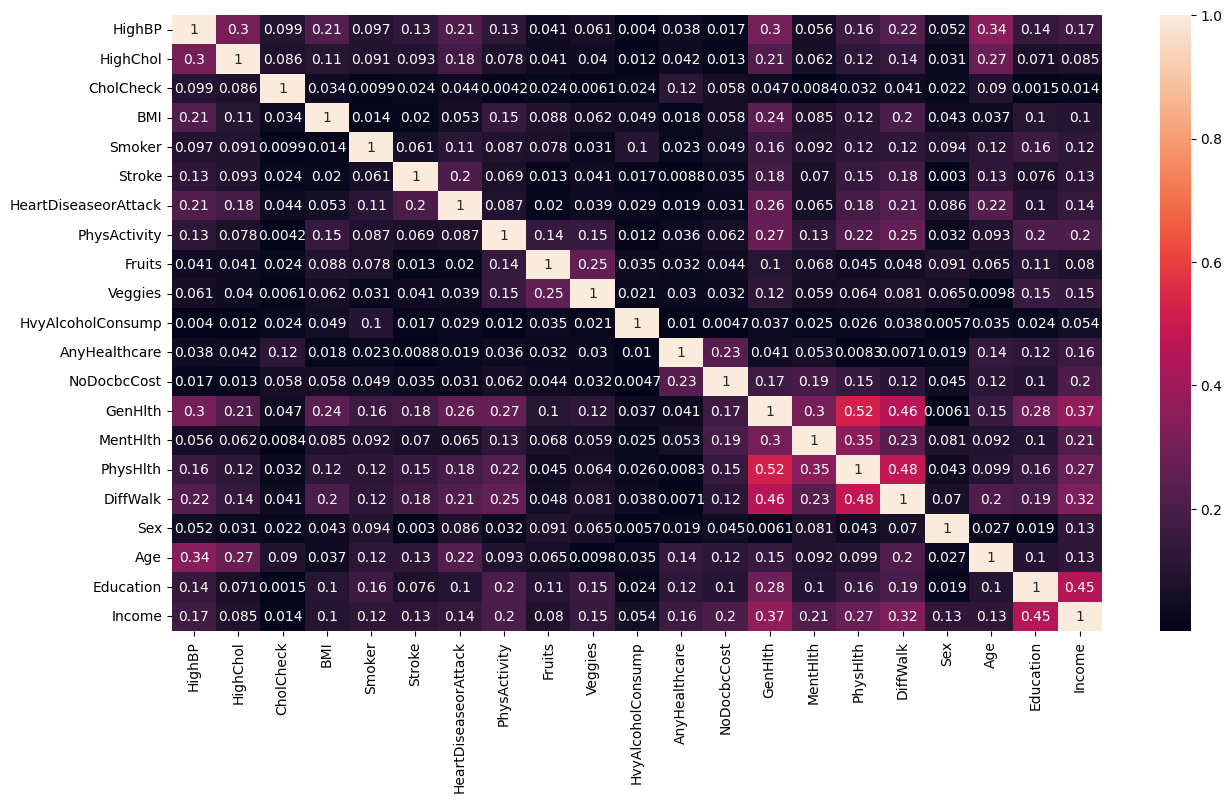

In [ ]:
# Correlation between variables
plt.figure(figsize = (15, 8))
sns.heatmap(X.corr().abs(),annot=True)

High correlation between GenHlth and PhysHlth, GenHlth and DiffWalk, and DiffWalk and Physhealth. 

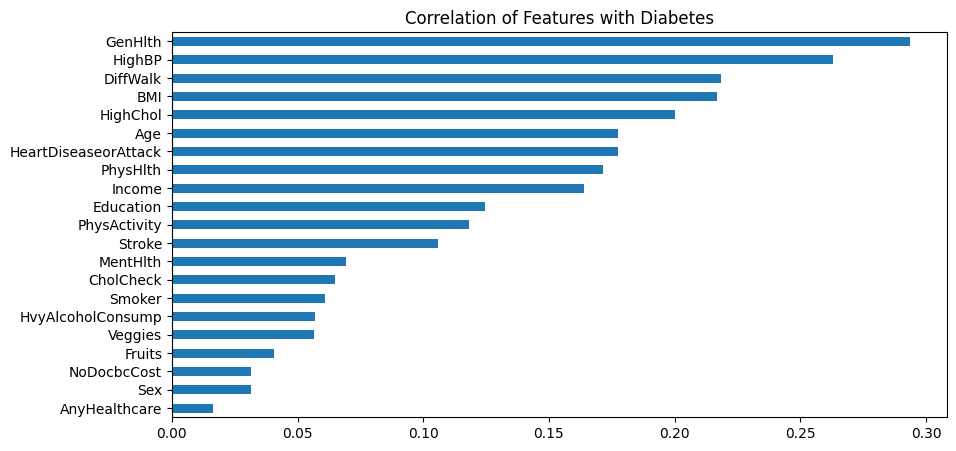

In [ ]:
# Visualizing variables' absolute correlation with target variable
data = pd.concat([X, y], axis=1)

correlation = data.corr()['Diabetes_binary'].drop('Diabetes_binary')
plt.figure(figsize=(10, 5))
correlation.abs().sort_values().plot(kind='barh')
plt.title('Correlation of Features with Diabetes')
plt.show()

AnyHealthcare, Sex, NoDocbcCost, and Fruits all have a low correlation with diabetes.

## Data Pre-Processing

In [5]:
#Dropping the variables with low correlation with diabetes
X.drop(columns=['AnyHealthcare', 'Sex', 'NoDocbcCost', 'Fruits'], inplace=True, axis=1)

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
# Dealing with imbalance by oversampling
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [7]:
# Split data for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Scaling the data
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

## Model Selection 

We want high recall because we don't want to miss any patients with diabetes. 

### Logistic Regression

In [ ]:
lg = LogisticRegression(max_iter = 1500)
lg.fit(X_train , y_train)
lg_y_pred_train = lg.predict(X_train)
lg_y_pred_test = lg.predict(X_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
lg_accuracy_train = accuracy_score(y_train, lg_y_pred_train)
print(f"Training Accuracy: {lg_accuracy_train}")

lg_recall_train = recall_score(y_train, lg_y_pred_train)
print(f"Training Recall: {lg_recall_train}")

lg_accuracy_test = accuracy_score(y_test, lg_y_pred_test)
print(f"Test Accuracy: {lg_accuracy_test}")

lg_recall_test = recall_score(y_test, lg_y_pred_test)
print(f"Test Recall: {lg_recall_test}")

Training Accuracy: 0.7348640556029473
Training Recall: 0.7512258758503888
Test Accuracy: 0.736551629376875
Test Recall: 0.754597001905374


### K Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
knn_y_pred_train = knn.predict(X_train)
knn_y_pred_test = knn.predict(X_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KernelInterrupted: Execution interrupted by the Jupyter kernel.

Takes a long time to run.

In [ ]:
knn_accuracy_train = accuracy_score(y_train, knn_y_pred_train)
print(f"Training Accuracy: {knn_accuracy_train}")

knn_recall_train = recall_score(y_train, knn_y_pred_train)
print(f"Training Recall: {knn_recall_train}")

knn_accuracy_test = accuracy_score(y_test, knn_y_pred_test)
print(f"Test Accuracy: {knn_accuracy_test}")

knn_recall_test = recall_score(y_test, knn_y_pred_test)
print(f"Test Recall: {knn_recall_test}")

NameError: name 'accuracy_score' is not defined

### Random Forest

In [9]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_y_pred_train = rf_classifier.predict(X_train)
rf_y_pred_test = rf_classifier.predict(X_test)

/tmp/ipykernel_821/1044826794.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


In [10]:
rf_accuracy_train = accuracy_score(y_train, rf_y_pred_train)
print(f"Training Accuracy: {rf_accuracy_train}")

rf_recall_train = recall_score(y_train, rf_y_pred_train)
print(f"Training Recall: {rf_recall_train}")

rf_accuracy_test = accuracy_score(y_test, rf_y_pred_test)
print(f"Test Accuracy: {rf_accuracy_test}")

rf_recall_test = recall_score(y_test, rf_y_pred_test)
print(f"Test Recall: {rf_recall_test}")

Training Accuracy: 0.9754046270904063
Training Recall: 0.9820796118393573
Test Accuracy: 0.8590239769162068
Test Recall: 0.9089323018296183


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(max_depth = 15)
dt.fit(X_train, y_train)
dt_y_pred_train = dt.predict(X_train)
dt_y_pred_test = dt.predict(X_test)

In [ ]:
dt_accuracy_train = accuracy_score(y_train, dt_y_pred_train)
print(f"Training Accuracy: {dt_accuracy_train}")

dt_recall_train = recall_score(y_train, dt_y_pred_train)
print(f"Training Recall: {dt_recall_train}")

dt_accuracy_test = accuracy_score(y_test, dt_y_pred_test)
print(f"Test Accuracy: {dt_accuracy_test}")

dt_recall_test = recall_score(y_test, dt_y_pred_test)
print(f"Test Recall: {dt_recall_test}")

Training Accuracy: 0.8019688893723486
Training Recall: 0.8602072402487798
Test Accuracy: 0.764181189456569
Test Recall: 0.8320056931659053


### Keras Neural Network

In [ ]:
nn = Sequential()
nn.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
nn.add(Dense(16, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

nn.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1)
nn_y_pred = nn.predict(X_test)
nn_y_pred = (nn_y_pred>.5)*1

2023-12-05 02:25:58.610967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-05 02:25:58.611012: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-05 02:25:58.611038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-be7a7c27-37ec-47f6-b58f-0a70d983c67e): /proc/driver/nvidia/version does not exist
2023-12-05 02:25:58.611419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Epoch 1/50
2457/2457 [==============================] - 13s 5ms/

Takes a long time to run.

In [ ]:
nn_classifcation_report = classification_report(y_test, nn_y_pred)
print(f"Classification Report:\n{nn_classifcation_report}")

nn_accuracy = accuracy_score(y_test, nn_y_pred)
print(f"Accuracy: {nn_accuracy}")

nn_recall = recall_score(y_test, nn_y_pred)
print(f"Recall: {nn_recall}")

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74     43773
           1       0.73      0.80      0.76     43561

    accuracy                           0.75     87334
   macro avg       0.75      0.75      0.75     87334
weighted avg       0.75      0.75      0.75     87334

Accuracy: 0.7507385439805803
Recall: 0.8021854411055761


The best model with both the highest accuracy and recall was random forest.

# Trying to improve the model 

## Feature Selection

In [ ]:
# Getting a fresh dataset without the processing from earlier
df = pd.merge(cdc_diabetes_health_indicators.data.features, cdc_diabetes_health_indicators.data.targets, left_index=True, right_index=True)

<AxesSubplot: >

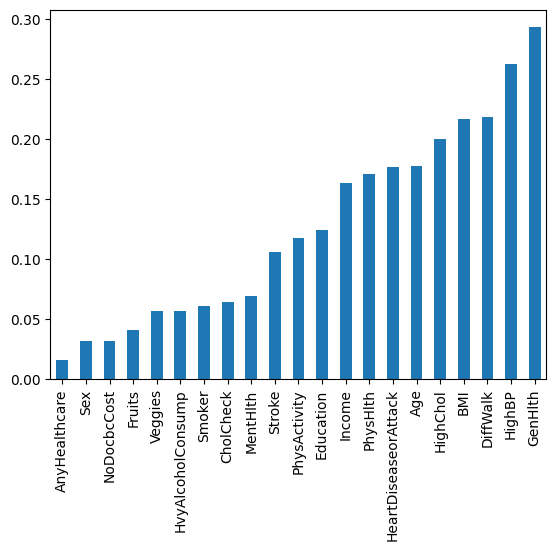

In [ ]:
df.corr().abs()['Diabetes_binary'][:-1].sort_values().plot(kind='bar')

<AxesSubplot: >

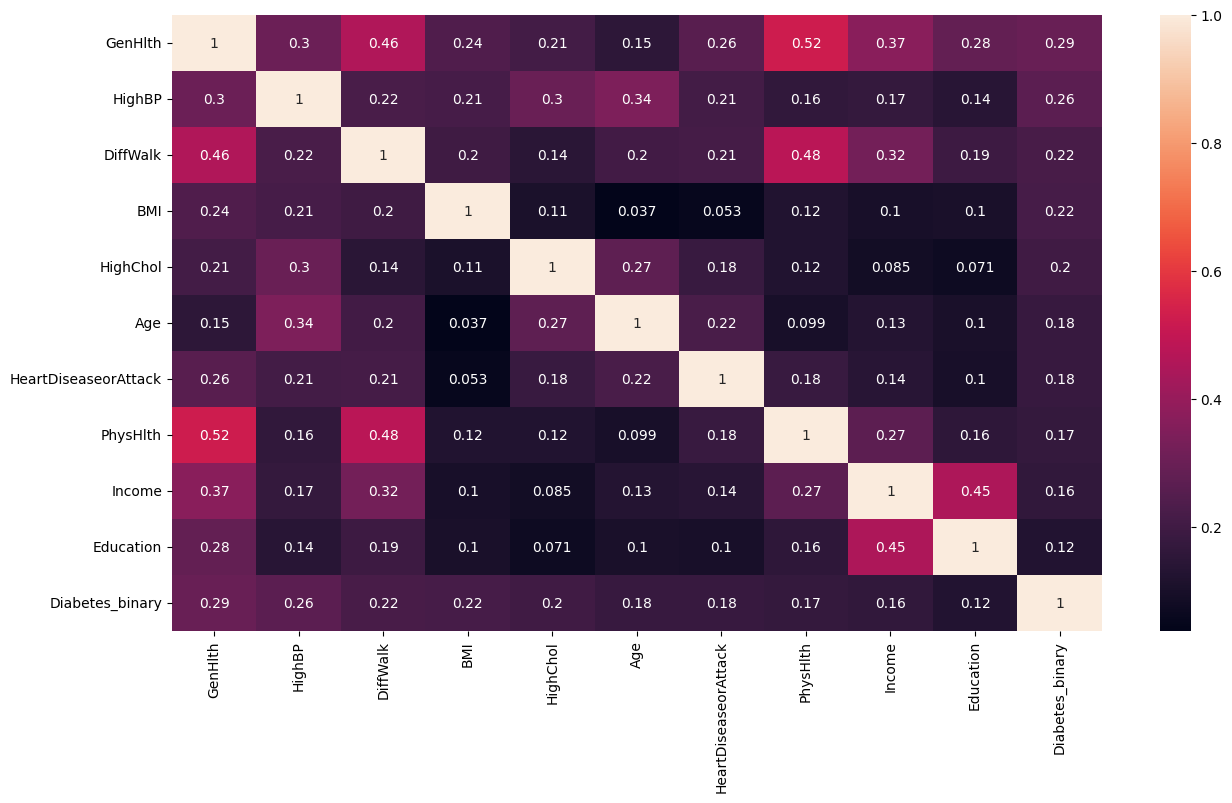

In [ ]:
# Filter df for top 10 correlated
df_filtered = df[['GenHlth', 'HighBP', 'DiffWalk', 'BMI', 'HighChol', 'Age', 'HeartDiseaseorAttack', 'PhysHlth', 'Income', 'Education', 'Diabetes_binary']]
plt.figure(figsize = (15, 8))
sns.heatmap(df_filtered.corr().abs(),annot=True)

In [ ]:
# Dropping the most highly correlated variable
df_filtered = df_filtered.drop("GenHlth", axis=1)

In [ ]:
#Pre-processing / create train_test_split

y_ = df_filtered['Diabetes_binary']
X_ = df_filtered.drop("Diabetes_binary", axis=1)

smote = SMOTE(random_state=42)
X_, y_ = smote.fit_resample(X_, y_)

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

In [ ]:
# Trying the model again
rf_classifier2 = RandomForestClassifier(random_state=42)
rf_classifier2.fit(X_train, y_train)
rf_y_pred_test = rf_classifier2.predict(X_test)
rf_y_pred_train = rf_classifier2.predict(X_train)

rf_accuracy_train2 = accuracy_score(y_train, rf_y_pred_train)
print(f"Training Accuracy: {rf_accuracy_train2}")

rf_recall_train2 = recall_score(y_train, rf_y_pred_train)
print(f"Training Recall: {rf_recall_train2}")

rf_accuracy_test2 = accuracy_score(y_test, rf_y_pred_test)
print(f"Test Accuracy: {rf_accuracy_test2}")

rf_recall_test2 = recall_score(y_test, rf_y_pred_test)
print(f"Test Recall: {rf_recall_test2}")

Training Accuracy: 0.8933771118757406
Training Recall: 0.9088818066863875
Test Accuracy: 0.8161311745711864
Test Recall: 0.8558573035513418


Not as good as the original model.

## Standardizing Certain Variables + Feature Engineering

In [11]:
# Getting a fresh dataset without the processing from earlier
df = pd.merge(cdc_diabetes_health_indicators.data.features, cdc_diabetes_health_indicators.data.targets, left_index=True, right_index=True)

In [12]:
#More feature selection
df.describe()

# nonbinary variables: BMI(12-98), GenHlth(0-5), PhysHlth(0-30), Age(1-13), Education(1-6), Income(1-8), MentHlth(0-30)
# Standardize variables

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_scale = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Combine variables with high colinearity: GenHlth, PhysHlth, DiffWalk
df["Gen+PhysHlth+DiffWalk"] = (df['GenHlth'] + df['PhysHlth'] + df['DiffWalk'])/3
df = df.drop(['PhysHlth', "GenHlth", 'DiffWalk'], axis=1)
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Veggies,HvyAlcoholConsump,MentHlth,Age,Education,Income,Diabetes_binary,Gen+PhysHlth
0,1,1,1,1.757936,1,0,0,0,1,0,1.998592,0.316900,-1.065595,-1.474487,0,1.521040
1,0,0,0,-0.511806,1,0,0,1,0,0,-0.429630,-0.337933,0.963272,-2.440138,0,-0.009766
2,1,1,1,-0.057858,0,0,0,0,0,0,3.617407,0.316900,-1.065595,0.939638,0,2.094570
3,1,0,1,-0.209174,0,0,0,1,1,0,-0.429630,0.971733,-2.080028,-0.026012,0,-0.321737
4,1,1,1,-0.663122,0,0,0,1,1,0,-0.024926,0.971733,-0.051162,-0.991662,0,-0.321737


In [13]:
y_ = df['Diabetes_binary']
X_ = df.drop("Diabetes_binary", axis=1)

smote = SMOTE(random_state=42)
X_, y_ = smote.fit_resample(X_, y_)

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

rf_classifier3 = RandomForestClassifier(random_state=42)
rf_classifier3.fit(X_train, y_train)
rf_y_pred_test = rf_classifier3.predict(X_test)
rf_y_pred_train = rf_classifier3.predict(X_train)

rf_accuracy_train2 = accuracy_score(y_train, rf_y_pred_train)
print(f"Training Accuracy: {rf_accuracy_train2}")

rf_recall_train2 = recall_score(y_train, rf_y_pred_train)
print(f"Training Recall: {rf_recall_train2}")

rf_accuracy_test2 = accuracy_score(y_test, rf_y_pred_test)
print(f"Test Accuracy: {rf_accuracy_test2}")

rf_recall_test2 = recall_score(y_test, rf_y_pred_test)
print(f"Test Recall: {rf_recall_test2}")

Training Accuracy: 0.9919675725809683
Training Recall: 0.988739679469941
Test Accuracy: 0.9079739849314128
Test Recall: 0.9106310690755492


Improved slightly :).

## 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=be7a7c27-37ec-47f6-b58f-0a70d983c67e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>